Todo:
* Need to plot some profiles to check the error introduced due to the linear interpolation from the irregularly spaced grid to the regularly spaced grid in (rho,z) space. Is the error acceptable? 
* See if we can learn a reduced representation of alpha (without coordinate information, how would we include coordinate system info?)

# Dependenciesaiofiles

In [2]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import warnings
from glob import glob
import pickle
import os
import json
import sys
import aiofiles # asynchronous file I/O operations
import asyncio # managing asynchronous operations
from pymagdisc.data.load_data import load_model
from pymagdisc.vis.plot_mdisc import plot_2d_cmp_exp_Pcold, plot_2d_cmp_exp_jphi
from pymagdisc.vis.plot_compare_contours_alpha import plot_compare_contours_alpha
from pymagdisc import config
import util
from create_dataset import read_filenames, create_model_dict, download_data_from_server, extract_data
warnings.filterwarnings("ignore")
plt.rcParams.update({'font.size': 14})
%load_ext autoreload
%autoreload 2

In [3]:
config.PATH_TO_DATA

'/home/ikc19/PhD/Code/mdisc/mdiscnet/data/MDISC/small_dataset/'

# Load data

In [5]:
# downloading .mat data from zudata6
# filename = 'jup_mdisc_kh1.52e+07_rmp60.00_nr601_nmu601.mat'
# download_data_from_server(filename)

File does not exist. Downloading...


In [49]:
# loading from .pkl
MD_EXP = util.load_result(f'{config.PATH_TO_DATA}jup_mdisc_kh1.02e+07_rmp100.00_nr601_nmu601.pkl')
MD_CMP = util.load_result(f'{config.PATH_TO_DATA}jup_mdisc_kh1.52e+07_rmp60.00_nr601_nmu601.pkl');

# loading from .mat
#MD_EXP = load_model(f'{config.PATH_TO_DATA}jup_mdisc_kh1.52e+07_rmp69.00_nr601_nmu601.pkl');
#MD_CMP = load_model(f'{config.PATH_TO_DATA}jup_mdisc_kh1.52e+07_rmp60.00_nr601_nmu601.pkl');

# Plot reference disc models

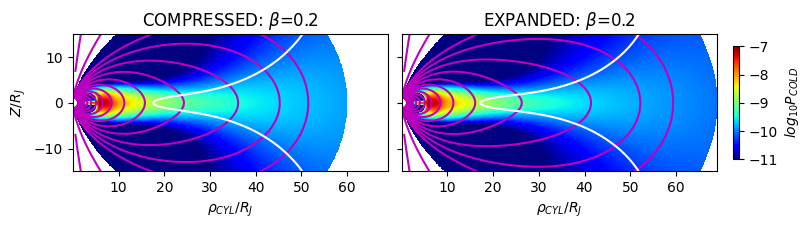

In [7]:
plot_2d_cmp_exp_Pcold(MD_CMP, MD_EXP)

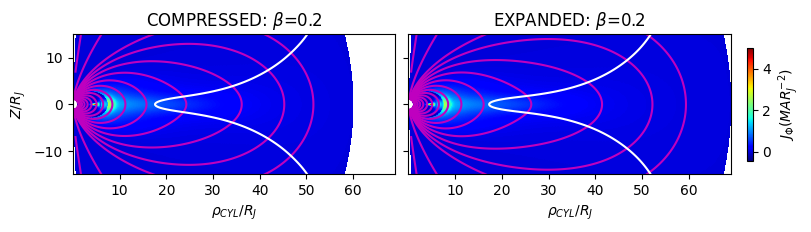

In [8]:
plot_2d_cmp_exp_jphi(MD_CMP, MD_EXP)

# Create v2d_B dataset with targets
The targets are the corresponding `Kh` and `rmp`.MD_EXP["c2d"]["rho"]

In [10]:
MD_EXP.keys()

dict_keys(['param', 'opts', 'info', 'consts', 'planet', 'disc', 'scales', 'dims', 'c2d', 'v2d', 'v1d', 'jacpoly', 'omega_relax', 'alpha_relax', 'itnr'])

Text(0, 0.5, '$\\mu$')

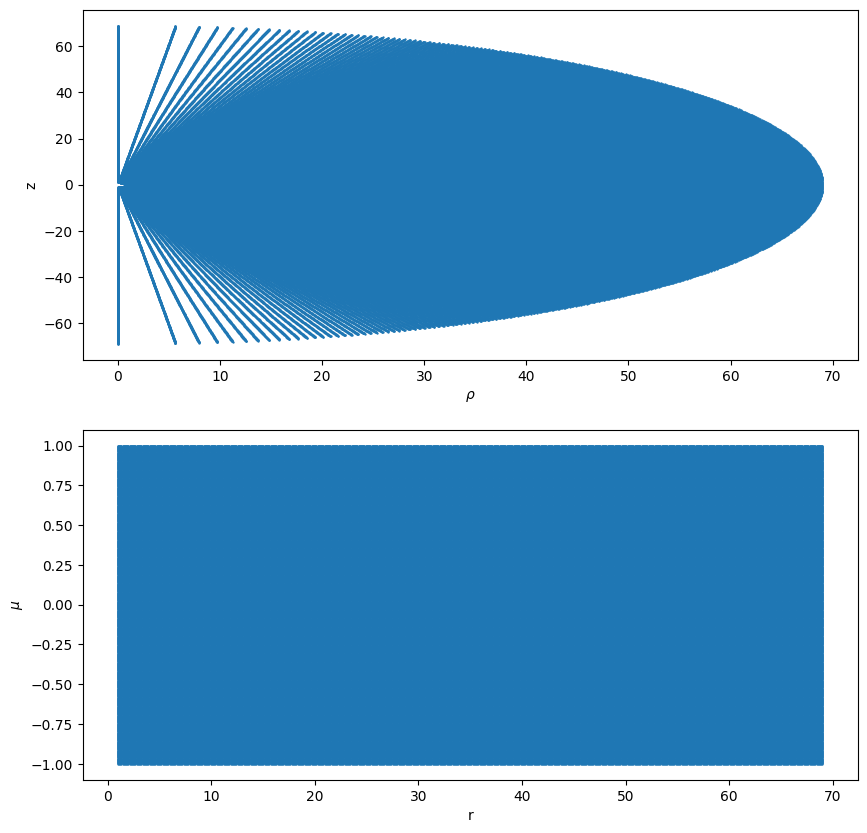

In [8]:
# visualize the r-\mu and z-\rho grid on which the mdisc model was created
fig, ax = plt.subplots(2,1, figsize=(10,10))
ax[0].scatter(MD_EXP["c2d"]["rho"], MD_EXP["c2d"]["z"], s=0.5)
ax[0].set_xlabel(r'$\rho$')
ax[0].set_ylabel('z')

ax[1].scatter(MD_EXP["c2d"]["r"], MD_EXP["c2d"]["mu"], s=0.5)
ax[1].set_xlabel('r')
ax[1].set_ylabel(r'$\mu$')

* Spherical coordinate (r and $\mu$) grid is uniform
* Cylindrical coordinate ($\rho$ and z) grid is not uniform 

We could save both representations to make two sets of training data and see which one performs better.

## $\rho z$ plane 

In [101]:
# find the min 
np.min(MD_EXP["c2d"]["rho"]), np.max(MD_EXP["c2d"]["rho"]), np.min(MD_EXP["c2d"]["z"]), np.max(MD_EXP["c2d"]["z"]), 

(0.0, 69.0, -69.0, 69.0)

In [62]:
# resample the grid to make uniform spacing
width = 512
height = 512
coord = 'rmu' #'zrho'

if coord == 'zrho':
    xi, yi, zi = util.resample_irreg2regGrid(x=MD_EXP["c2d"]["rho"],
                                y=MD_EXP["c2d"]["z"],
                                z=MD_EXP["v2d"]["alpha"],
                                xi=np.linspace(np.min(MD_EXP["c2d"]["rho"]), np.max(MD_EXP["c2d"]["rho"]), width),
                                yi=np.linspace(np.min(MD_EXP["c2d"]["z"]), np.max(MD_EXP["c2d"]["z"]), height),
                                interp_method='cubic')
elif coord == 'rmu':
    xi, yi, zi = util.resample_irreg2regGrid(x=MD_EXP["c2d"]["r"],
                                y=MD_EXP["c2d"]["mu"],
                                z=MD_EXP["v2d"]["alpha"],
                                xi=np.linspace(np.min(MD_EXP["c2d"]["r"]), np.max(MD_EXP["c2d"]["r"]), width),
                                yi=np.linspace(np.min(MD_EXP["c2d"]["mu"]), np.max(MD_EXP["c2d"]["mu"]), height),
                                interp_method='nearest')

In [35]:
# number of nans in the original data
np.isnan(MD_EXP["v2d"]["alpha"]).sum()

0

In [63]:
# number of nans in the interpolated data
np.isnan(zi).sum(), np.isnan(np.log10(zi)).sum()

(0, 0)

Causes of `Nans` in the input data:

Interpolation
- `nan` are being introduced into the data after 'linear' and 'cubic' interpolation for `coord='zrho'` because these interpolation methods do not extrapolate, but instead fill the values which are not within the input area with `nan` by default. Since the original `zrho` coordinate space is not a uniform grid, some parts of this grid is not in the input area and thus would yield `nan` (see left figure below - white space would lead to `nan` values in the uniform `zrho` grid). 

- No `nan` produced if we use the `coord = 'rmu'`, since this is already a uniform grid, so we are always within the input area. 

Log
- `nan` are also produced when taking the log of negative data, which would have resulted from the 'linear', and 'cubic' interpolation. However, using 'nearest' interpolation would prevent nans because it would not yield negative values (original data only positive). 

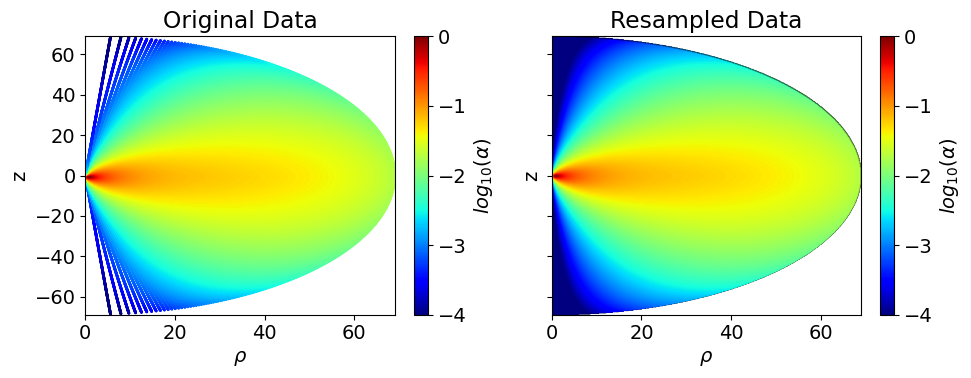

In [33]:
# Plot the original and resampled data
fig, ax = plt.subplots(1,2,figsize=(10, 4), sharex=True, sharey=True)

s = ax[0].scatter(MD_EXP["c2d"]["rho"],
            MD_EXP["c2d"]["z"],
            c=np.log10(MD_EXP["v2d"]["alpha"]),
            s=1,
        vmin=-4,
        vmax=0,
        cmap="jet",)
ax[0].set_xlabel(r'$\rho$')
ax[0].set_ylabel('z')
ax[0].set_title('Original Data')
plt.colorbar(s, label=r'$log_{10}(\alpha)$', ax=ax[0])

pc = ax[1].pcolormesh(xi, yi, np.log10(zi),
        shading="gouraud",
        vmin=-4,
        vmax=0,
        cmap="jet")
ax[1].set_xlabel(r'$\rho$')
ax[1].set_ylabel('z')
ax[1].set_title('Resampled Data')
plt.colorbar(pc, label=r'$log_{10}(\alpha)$', ax=ax[1])

plt.tight_layout()
plt.show()


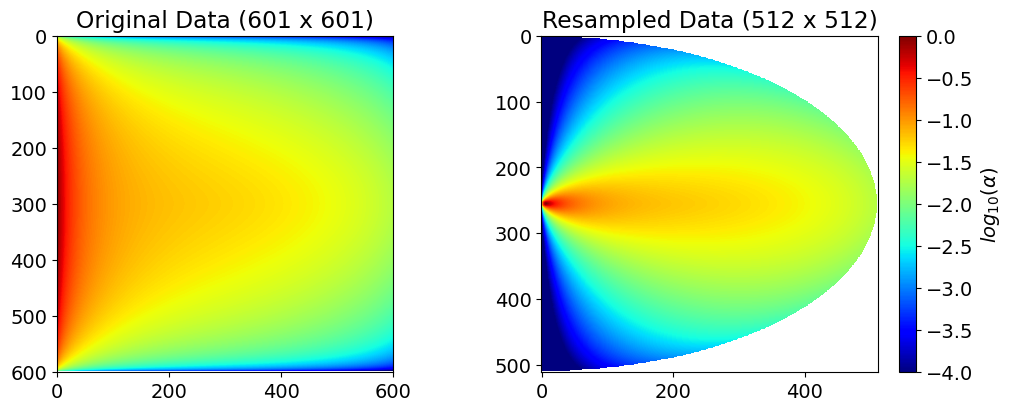

In [20]:
# interpolated data (on a regular grid in (\rho,z)) can be plotted with imshow as an image without the (rho,z) coordinates
fig, ax = plt.subplots(1,2,figsize=(10, 4), constrained_layout=True)

s = ax[0].imshow(np.log10(MD_EXP["v2d"]["alpha"]), vmin=-4,
        vmax=0, 
        cmap="jet")
ax[0].set_title('Original Data (601 x 601)')

s = ax[1].imshow(np.log10(zi), vmin=-4,
        vmax=0,
        cmap="jet")
ax[1].set_title('Resampled Data (512 x 512)')
plt.colorbar(s,label=r'$log_{10}(\alpha)$', ax=ax[1])

In [ ]:
# save the original v2d data
filenames = glob(f"{config.PATH_TO_DATA}*.mat")
samples_v2d_B = []
samples_target = []
for filename in tqdm(filenames):
    filename_split = filename.split('_')
    MD = load_model(filename)
    samples_v2d_B.append(MD["v2d"]["B"])
    samples_target.append(filename_split[3] + '_' + filename_split[4])

In [55]:
width=601
height=601
samples_v2d_B = np.array(samples_v2d_B).reshape(-1,width,height,1) # (nSamples,width,height,nChannels)
util.save_result(samples_v2d_B, config.PATH_TO_DATA+'samples_v2d_B_601x601.pkl')
util.save_result(np.array(samples_target), config.PATH_TO_DATA+'samples_target.pkl')

In [56]:
np.array(samples_v2d_B).shape, samples_target

((15, 601, 601, 1),
 ['kh1.52e+07_rmp63.50',
  'kh1.52e+07_rmp62.50',
  'kh1.52e+07_rmp60.00',
  'kh1.52e+07_rmp63.00',
  'kh1.52e+07_rmp61.50',
  'kh1.52e+07_rmp62.00',
  'kh1.52e+07_rmp60.50',
  'kh1.52e+07_rmp65.00',
  'kh1.52e+07_rmp67.50',
  'kh1.52e+07_rmp64.50',
  'kh1.52e+07_rmp66.00',
  'kh1.52e+07_rmp67.00',
  'kh1.52e+07_rmp68.50',
  'kh1.52e+07_rmp68.00',
  'kh1.52e+07_rmp69.00'])

In [57]:
# save the interpolated regularly spaced v2d data
filenames = glob(f"{config.PATH_TO_DATA}*.mat")
width = 512
height = 512
samples_v2d_B = []
samples_target = []
for filename in tqdm(filenames):
    filename_split = filename.split('_')
    MD = load_model(filename)
    xi, yi, zi = util.resample_irreg2regGrid(x=MD["c2d"]["rho"],
                            y=MD["c2d"]["z"],
                            z=MD["v2d"]["B"],
                            xi=np.linspace(np.min(MD["c2d"]["rho"]), np.max(MD["c2d"]["rho"]), width),
                            yi=np.linspace(np.min(MD["c2d"]["z"]), np.max(MD["c2d"]["z"]), height),
                            method='linear')
    samples_v2d_B.append(zi)
    samples_target.append(filename_split[3] + '_' + filename_split[4])

samples_v2d_B = np.array(samples_v2d_B).reshape(-1,width,height,1) # (nSamples,width,height,nChannels)
util.save_result(samples_v2d_B, config.PATH_TO_DATA+'samples_v2d_B_rhoz_512x512.pkl')
#util.save_result(np.array(samples_target), config.PATH_TO_DATA+'samples_target.pkl')

100%|██████████| 15/15 [01:52<00:00,  7.47s/it]


In [58]:
samples_v2d_B.shape

(15, 512, 512, 1)

## $r\mu$ plane

In [11]:
# resample the grid to make uniform 
width = 512
height = 512
xi, yi, zi = util.resample_irreg2regGrid(x=MD_EXP["c2d"]["r"],
                            y=MD_EXP["c2d"]["mu"],
                            z=MD_EXP["v2d"]["B"],
                            xi=np.linspace(np.min(MD_EXP["c2d"]["r"]), np.max(MD_EXP["c2d"]["r"]), width),
                            yi=np.linspace(np.min(MD_EXP["c2d"]["mu"]), np.max(MD_EXP["c2d"]["mu"]), height),
                            method='linear')

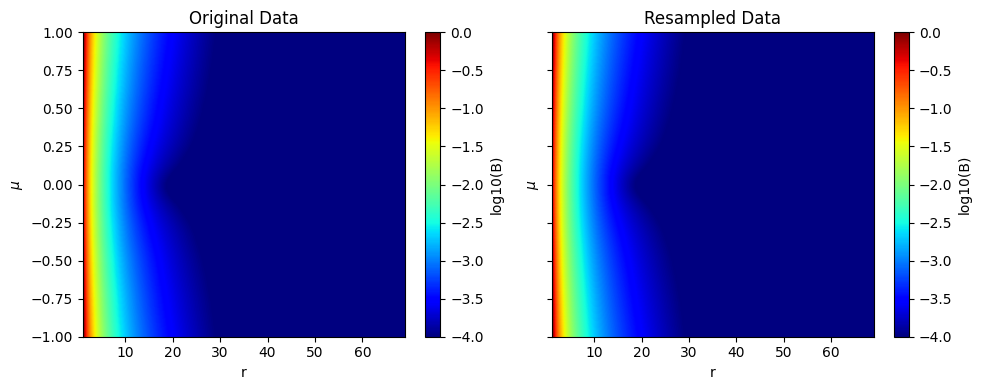

In [12]:
# Plot the original and resampled data
fig, ax = plt.subplots(1,2,figsize=(10, 4), sharex=True, sharey=True)

s = ax[0].scatter(MD_EXP["c2d"]["r"],
            MD_EXP["c2d"]["mu"],
            c=np.log10(MD_EXP["v2d"]["B"]),
            s=1,
        vmin=-4,
        vmax=0,
        cmap="jet",)
ax[0].set_xlabel('r')
ax[0].set_ylabel(r'$\mu$')
ax[0].set_title('Original Data')
plt.colorbar(s, label='log10(B)', ax=ax[0])

pc = ax[1].pcolormesh(xi, yi, np.log10(zi),
        shading="gouraud",
        vmin=-4,
        vmax=0,
        cmap="jet")
ax[1].set_xlabel('r')
ax[1].set_ylabel(r'$\mu$')
ax[1].set_title('Resampled Data')
plt.colorbar(pc, label='log10(B)', ax=ax[1])

plt.tight_layout()
plt.show()

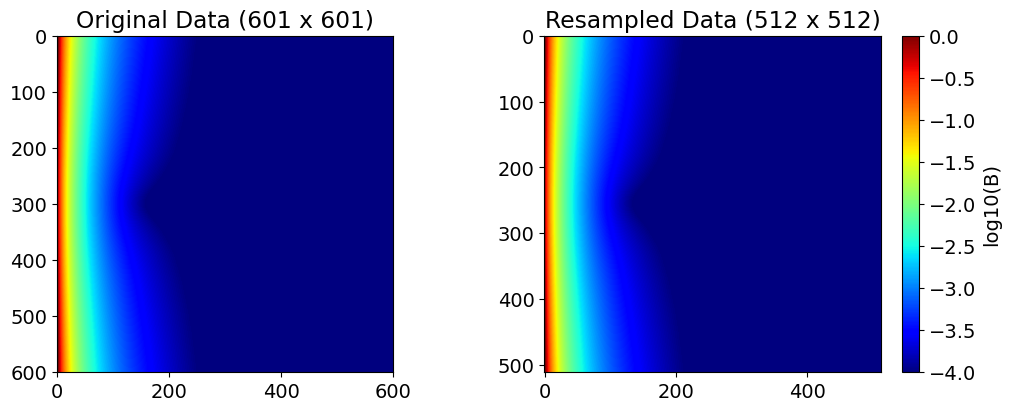

In [36]:
# interpolated data (on a regular grid) can be plotted with imshow as an image
fig, ax = plt.subplots(1,2,figsize=(10, 4), constrained_layout=True)

s = ax[0].imshow(np.log10(MD_EXP["v2d"]["B"]), vmin=-4,
        vmax=0, 
        cmap="jet")
ax[0].set_title('Original Data (601 x 601)')

s = ax[1].imshow(np.log10(zi), vmin=-4,
        vmax=0,
        cmap="jet")
ax[1].set_title('Resampled Data (512 x 512)')
plt.colorbar(s, label='log10(B)', ax=ax[1])

         

In [60]:
# save the interpolated regularly spaced v2d data
filenames = glob(f"{config.PATH_TO_DATA}*.mat")
width = 512
height = 512
samples_v2d_B = []
samples_target = []
for filename in tqdm(filenames):
    filename_split = filename.split('_')
    MD = load_model(filename)
    xi, yi, zi = util.resample_irreg2regGrid(x=MD["c2d"]["r"],
                            y=MD["c2d"]["mu"],
                            z=MD["v2d"]["B"],
                            xi=np.linspace(np.min(MD["c2d"]["r"]), np.max(MD["c2d"]["r"]), width),
                            yi=np.linspace(np.min(MD["c2d"]["mu"]), np.max(MD["c2d"]["mu"]), height),
                            method='linear')
    samples_v2d_B.append(zi)
    samples_target.append(filename_split[3] + '_' + filename_split[4])
    
samples_v2d_B = np.array(samples_v2d_B).reshape(-1,width,height,1) # (nSamples,nChannels,width,height)
util.save_result(samples_v2d_B, config.PATH_TO_DATA+'samples_v2d_B_rmu_512x512.pkl')
#util.save_result(np.array(samples_target), config.PATH_TO_DATA+'samples_target.pkl')

100%|██████████| 15/15 [01:57<00:00,  7.81s/it]


In [61]:
samples_v2d_B.shape

(15, 512, 512, 1)

# Modify saved data

In [50]:
# rotate data
width = height = 512
samples_v2d_B = load.load_result(config.PATH_TO_DATA+'samples_v2d_B_rmu_512x512.pkl')
samples_v2d_B = samples_v2d_B.reshape(-1,width,height,1) # (nSamples,nChannels,width,height)


In [51]:
samples_v2d_B.shape

(15, 512, 512, 1)

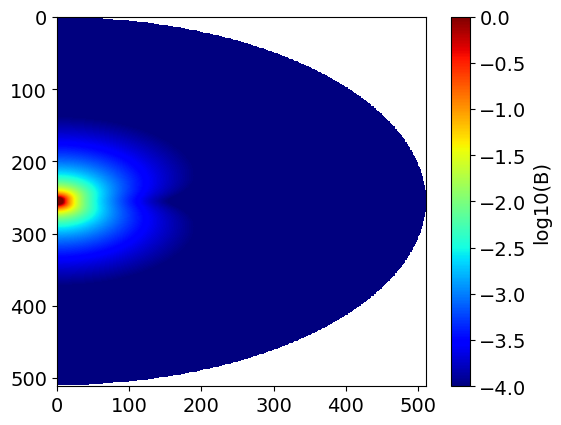

In [52]:
# verify it is still correct
s = plt.imshow(np.log10(samples_v2d_B[0]), vmin=-4,
        vmax=0,
        cmap="jet")
plt.colorbar(s, label='log10(B)')

In [48]:
# save
util.save_result(samples_v2d_B, config.PATH_TO_DATA+'samples_v2d_B_rmu_512x512.pkl')

# Create large dataset
Input: 
- `filenames`
- rmp: 50 to 100
- Kh: 1e7 to 3e7
- basically every model in `jup_mdisc_filenames.txt`

Output: 
- coordinate grids: `c2d.r, c2d.mu`. Note. the positional grid is different for each model because it is a grid with nr and nmu number of points over the `rmax` distance.

- .pkl file for all variables of interest (-1, 601, 601, 7), where -1 corresponds to the number of filenames, and 7 corresponds to `c2d.r, c2d.mu, v2d.alpha, v2d.Br, v2d.Bth, v2d.PcEq and v2d.PhEq`. 

N.B. According to Dimitris, `v2d.alpha` is most sensitive to `Kh` and `rmp` and all other variables can be derived from it. As such, it may suffice to just use `v2d.alpha` (-1, 512, 512, 1) to train the model. 

Storage size:
For saving all 7 variables:
- `.json`: 73.4MB / model
- `.pkl`: 19.3MB / model

If saving only 1 variable (`v2d.alpha`): 
- '.pkl': ~2.5 MB / model

In [35]:
# Loop over filenames from `jup_mdisc_filenames.txt`
filenames = read_filenames(filenames_path=config.PATH_TO_DATA+'jup_mdisc_filenames.txt')

In [92]:
# Loop over filenames from already downloaded models .mat files
#filenames = glob(f"{config.PATH_TO_DATA}*.mat")

In [36]:
# Sequential loop (if it runs into an OSError, it means the file transfer was not successful. Delete the .mat file and run again)
for i, filename in enumerate(tqdm(filenames)):
    filename = filename.split('/')[-1]
    print(i, filename)
    
    if i >= 9435 and i <= 9453:
        pkl_filename = f"{filename[0:-4]}.pkl"
        data_filename = f"{config.PATH_TO_DATA}{filename}"

        # if the model .pkl file already exists, go to next filename
        if os.path.isfile(f"{config.PATH_TO_DATA}{pkl_filename}"):
            print("Next file.")
            continue
        else:
            # Use `load_catalog` to scp the file over
            download_data_from_server(filename)

            # Extract the data we want
            data_extracted = False
            while not data_extracted:
                if filename in os.listdir(config.PATH_TO_DATA):
                    data_extracted = True
                    try:
                        model_dict = extract_data(filename)
                    except OSError as e:
                        data_extracted = True
                        print(f'{i} {filename} | OSError {e}', file=open('./create_dataset.log', 'a'))
                else:
                    time.sleep(1)

            # Save model_dict_list
            print("Saving model_dict ...")
            util.save_result(model_dict, config.PATH_TO_DATA+filename[0:-4]+'.pkl')
            print("Complete.")

            # delete the `.mat` file, if the model .pkl file is saved
            pkl_saved = False
            while not pkl_saved:
                if f"{filename[0:-4]}.pkl" in os.listdir(config.PATH_TO_DATA):
                    pkl_saved = True
                    os.remove(f"{config.PATH_TO_DATA}{filename}")
                    print(f"{filename} removed.")
                else:
                    time.sleep(1)

        # if i == 3222:
        #      break

  0%|          | 0/10201 [00:00<?, ?it/s]

0 jup_mdisc_kh1.02e+07_rmp100.00_nr601_nmu601.mat
1 jup_mdisc_kh1.02e+07_rmp50.00_nr601_nmu601.mat
2 jup_mdisc_kh1.02e+07_rmp50.50_nr601_nmu601.mat
3 jup_mdisc_kh1.02e+07_rmp51.00_nr601_nmu601.mat
4 jup_mdisc_kh1.02e+07_rmp51.50_nr601_nmu601.mat
5 jup_mdisc_kh1.02e+07_rmp52.00_nr601_nmu601.mat
6 jup_mdisc_kh1.02e+07_rmp52.50_nr601_nmu601.mat
7 jup_mdisc_kh1.02e+07_rmp53.00_nr601_nmu601.mat
8 jup_mdisc_kh1.02e+07_rmp53.50_nr601_nmu601.mat
9 jup_mdisc_kh1.02e+07_rmp54.00_nr601_nmu601.mat
10 jup_mdisc_kh1.02e+07_rmp54.50_nr601_nmu601.mat
11 jup_mdisc_kh1.02e+07_rmp55.00_nr601_nmu601.mat
12 jup_mdisc_kh1.02e+07_rmp55.50_nr601_nmu601.mat
13 jup_mdisc_kh1.02e+07_rmp56.00_nr601_nmu601.mat
14 jup_mdisc_kh1.02e+07_rmp56.50_nr601_nmu601.mat
15 jup_mdisc_kh1.02e+07_rmp57.00_nr601_nmu601.mat
16 jup_mdisc_kh1.02e+07_rmp57.50_nr601_nmu601.mat
17 jup_mdisc_kh1.02e+07_rmp58.00_nr601_nmu601.mat
18 jup_mdisc_kh1.02e+07_rmp58.50_nr601_nmu601.mat
19 jup_mdisc_kh1.02e+07_rmp59.00_nr601_nmu601.mat
20 jup_md

 93%|█████████▎| 9436/10201 [00:06<00:00, 1384.94it/s]

jup_mdisc_kh2.8e+07_rmp70.50_nr601_nmu601.mat removed.
9436 jup_mdisc_kh2.8e+07_rmp71.00_nr601_nmu601.mat
File does not exist. Downloading...
Saving model_dict ...
Complete.
jup_mdisc_kh2.8e+07_rmp71.00_nr601_nmu601.mat removed.
9437 jup_mdisc_kh2.8e+07_rmp71.50_nr601_nmu601.mat
File does not exist. Downloading...


 93%|█████████▎| 9436/10201 [00:17<00:00, 1384.94it/s]

Saving model_dict ...
Complete.


 93%|█████████▎| 9438/10201 [00:19<00:02, 378.47it/s] 

jup_mdisc_kh2.8e+07_rmp71.50_nr601_nmu601.mat removed.
9438 jup_mdisc_kh2.8e+07_rmp72.00_nr601_nmu601.mat
File does not exist. Downloading...
Saving model_dict ...
Complete.


 93%|█████████▎| 9439/10201 [00:25<00:03, 249.57it/s]

jup_mdisc_kh2.8e+07_rmp72.00_nr601_nmu601.mat removed.
9439 jup_mdisc_kh2.8e+07_rmp72.50_nr601_nmu601.mat
File does not exist. Downloading...
Saving model_dict ...
Complete.
jup_mdisc_kh2.8e+07_rmp72.50_nr601_nmu601.mat removed.
9440 jup_mdisc_kh2.8e+07_rmp73.00_nr601_nmu601.mat
File does not exist. Downloading...


 93%|█████████▎| 9439/10201 [00:37<00:03, 249.57it/s]

Saving model_dict ...
Complete.


 93%|█████████▎| 9441/10201 [00:38<00:05, 126.78it/s]

jup_mdisc_kh2.8e+07_rmp73.00_nr601_nmu601.mat removed.
9441 jup_mdisc_kh2.8e+07_rmp73.50_nr601_nmu601.mat
File does not exist. Downloading...
Saving model_dict ...
Complete.


 93%|█████████▎| 9442/10201 [00:44<00:08, 94.06it/s] 

jup_mdisc_kh2.8e+07_rmp73.50_nr601_nmu601.mat removed.
9442 jup_mdisc_kh2.8e+07_rmp74.00_nr601_nmu601.mat
File does not exist. Downloading...
Saving model_dict ...
Complete.
jup_mdisc_kh2.8e+07_rmp74.00_nr601_nmu601.mat removed.
9443 jup_mdisc_kh2.8e+07_rmp74.50_nr601_nmu601.mat
File does not exist. Downloading...


 93%|█████████▎| 9444/10201 [00:57<00:14, 53.53it/s]

Saving model_dict ...
Complete.
jup_mdisc_kh2.8e+07_rmp74.50_nr601_nmu601.mat removed.
9444 jup_mdisc_kh2.8e+07_rmp75.00_nr601_nmu601.mat
File does not exist. Downloading...


 93%|█████████▎| 9445/10201 [01:03<00:18, 41.25it/s]

Saving model_dict ...
Complete.
jup_mdisc_kh2.8e+07_rmp75.00_nr601_nmu601.mat removed.
9445 jup_mdisc_kh2.8e+07_rmp75.50_nr601_nmu601.mat
File does not exist. Downloading...
Saving model_dict ...
Complete.
jup_mdisc_kh2.8e+07_rmp75.50_nr601_nmu601.mat removed.
9446 jup_mdisc_kh2.8e+07_rmp76.00_nr601_nmu601.mat
File does not exist. Downloading...
Saving model_dict ...
Complete.
jup_mdisc_kh2.8e+07_rmp76.00_nr601_nmu601.mat removed.
9447 jup_mdisc_kh2.8e+07_rmp76.50_nr601_nmu601.mat
File does not exist. Downloading...


 93%|█████████▎| 9445/10201 [01:17<00:18, 41.25it/s]

Saving model_dict ...
Complete.


 93%|█████████▎| 9448/10201 [01:22<00:36, 20.83it/s]

jup_mdisc_kh2.8e+07_rmp76.50_nr601_nmu601.mat removed.
9448 jup_mdisc_kh2.8e+07_rmp77.00_nr601_nmu601.mat
File does not exist. Downloading...
Saving model_dict ...
Complete.
jup_mdisc_kh2.8e+07_rmp77.00_nr601_nmu601.mat removed.


 93%|█████████▎| 9449/10201 [01:28<00:44, 16.87it/s]

9449 jup_mdisc_kh2.8e+07_rmp77.50_nr601_nmu601.mat
File does not exist. Downloading...
Saving model_dict ...
Complete.
jup_mdisc_kh2.8e+07_rmp77.50_nr601_nmu601.mat removed.
9450 jup_mdisc_kh2.8e+07_rmp78.00_nr601_nmu601.mat
File does not exist. Downloading...
Saving model_dict ...
Complete.
jup_mdisc_kh2.8e+07_rmp78.00_nr601_nmu601.mat removed.
9451 jup_mdisc_kh2.8e+07_rmp78.50_nr601_nmu601.mat
File does not exist. Downloading...
Saving model_dict ...
Complete.


 93%|█████████▎| 9449/10201 [01:47<00:44, 16.87it/s]

jup_mdisc_kh2.8e+07_rmp78.50_nr601_nmu601.mat removed.
9452 jup_mdisc_kh2.8e+07_rmp79.00_nr601_nmu601.mat
File does not exist. Downloading...


 93%|█████████▎| 9453/10201 [01:53<01:31,  8.14it/s]

Saving model_dict ...
Complete.
jup_mdisc_kh2.8e+07_rmp79.00_nr601_nmu601.mat removed.
9453 jup_mdisc_kh2.8e+07_rmp79.50_nr601_nmu601.mat
File does not exist. Downloading...
Saving model_dict ...
Complete.


100%|██████████| 10201/10201 [01:59<00:00, 85.18it/s]

jup_mdisc_kh2.8e+07_rmp79.50_nr601_nmu601.mat removed.
9454 jup_mdisc_kh2.8e+07_rmp80.00_nr601_nmu601.mat
9455 jup_mdisc_kh2.8e+07_rmp80.50_nr601_nmu601.mat
9456 jup_mdisc_kh2.8e+07_rmp81.00_nr601_nmu601.mat
9457 jup_mdisc_kh2.8e+07_rmp81.50_nr601_nmu601.mat
9458 jup_mdisc_kh2.8e+07_rmp82.00_nr601_nmu601.mat
9459 jup_mdisc_kh2.8e+07_rmp82.50_nr601_nmu601.mat
9460 jup_mdisc_kh2.8e+07_rmp83.00_nr601_nmu601.mat
9461 jup_mdisc_kh2.8e+07_rmp83.50_nr601_nmu601.mat
9462 jup_mdisc_kh2.8e+07_rmp84.00_nr601_nmu601.mat
9463 jup_mdisc_kh2.8e+07_rmp84.50_nr601_nmu601.mat
9464 jup_mdisc_kh2.8e+07_rmp85.00_nr601_nmu601.mat
9465 jup_mdisc_kh2.8e+07_rmp85.50_nr601_nmu601.mat
9466 jup_mdisc_kh2.8e+07_rmp86.00_nr601_nmu601.mat
9467 jup_mdisc_kh2.8e+07_rmp86.50_nr601_nmu601.mat
9468 jup_mdisc_kh2.8e+07_rmp87.00_nr601_nmu601.mat
9469 jup_mdisc_kh2.8e+07_rmp87.50_nr601_nmu601.mat
9470 jup_mdisc_kh2.8e+07_rmp88.00_nr601_nmu601.mat
9471 jup_mdisc_kh2.8e+07_rmp88.50_nr601_nmu601.mat
9472 jup_mdisc_kh2.8e+07_rm

In [38]:
len(glob('./data/MDISC/small_dataset/*.pkl')), filenames[i]

(10201, 'jup_mdisc_kh3e+07_rmp99.50_nr601_nmu601.mat')

## [NOT WORKING] Asynchronous loop to download, extract, save, and delete

In [23]:
async def download_data_from_server_async(filename):
    await download_data_from_server(filename)

async def extract_data_async(filename):
    model_dict = extract_data(filename)
    return model_dict

async def save_data_async(model_dict, filename):
    await util.save_result(model_dict, config.PATH_TO_DATA+filename[0:-4]+'.pkl')  # Serialize data to binary

async def main():
    filenames = read_filenames(filenames_path=config.PATH_TO_DATA+'jup_mdisc_filenames.txt')[10:11]
    tasks = []

    for i, filename in enumerate(tqdm(filenames)):
        filename = filename.split('/')[-1]
        print(filename)

        pkl_filename = f"{filename[0:-4]}.pkl"
        data_filename = f"{config.PATH_TO_DATA}{filename}"

        # if the model .pkl file already exists, go to the next filename
        if os.path.isfile(f"{config.PATH_TO_DATA}{pkl_filename}"):
            print("Next file.")
            continue
        else:
            # Use `download_data_from_server` to simulate downloading the file
            tasks.append(download_data_from_server_async(filename))
            model_dict = await extract_data_async(filename)

            # Save model_dict_list
            print("Saving model_dict ...")
            tasks.append(save_data_async(model_dict, f"{config.PATH_TO_DATA}{pkl_filename}"))
            print("Complete.")

            # Delete the `.mat` file if the model .pkl file is saved
            os.remove(data_filename)
            print(f"{data_filename} removed.")
        
        break

    await asyncio.gather(*tasks)

loop = asyncio.get_event_loop()
loop.run_until_complete(main())

RuntimeError: This event loop is already running

## Interpolate to 512x512 and save `v2d.alpha` only

In [16]:
filenames = sorted(glob(f"{config.PATH_TO_DATA}jup_mdisc*.pkl"))

In [17]:
len(filenames)

10201

In [18]:
# save the interpolated regularly spaced v2d data
filenames = sorted(glob(f"{config.PATH_TO_DATA}jup_mdisc*.pkl"))
width = 512
height = 512
interp_method = 'cubic'
batches = [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
for i, batch in enumerate(batches):
    if i <= 9: continue
    print(i)
    train_v2d = []
    train_labels = []
    for j, filename in enumerate(tqdm(filenames[batch:batch+1000])):
        filename_split = filename.split('/')[-1].split('_')
        print(f'{j} {filename_split}', file=open('./create_dataset.log', 'a'))
        
        MD = util.load_result(filename)
        
        xi, yi, zi = util.resample_irreg2regGrid(x=MD["c2d"]["r"],
                                y=MD["c2d"]["mu"],
                                z=MD["v2d"]["alpha"],
                                xi=np.linspace(np.min(MD["c2d"]["r"]), np.max(MD["c2d"]["r"]), width),
                                yi=np.linspace(np.min(MD["c2d"]["mu"]), np.max(MD["c2d"]["mu"]), height),
                                interp_method=interp_method)
        train_v2d.append(zi)
        train_labels.append(filename_split[2] + '_' + filename_split[3])

    train_v2d = np.array(train_v2d).reshape(-1,height,width,1) # (nSamples,height,width,nChannels)
    util.save_result(train_v2d, config.PATH_TO_DATA+f"train/train_v2d_alpha_{interp_method}_512x512_{i+1}.pkl")
    util.save_txt(data=train_labels, filename=config.PATH_TO_DATA+f'train/train_labels_{i+1}.txt')

10


100%|██████████| 201/201 [29:08<00:00,  8.70s/it]


In [51]:
np.array(util.load_txt(config.PATH_TO_DATA+'train/train_labels_11.txt').split('\n')).shape, util.load_result(config.PATH_TO_DATA+'train/train_v2d_alpha_cubic_512x512_11.pkl').shape

((1000,), (1000, 512, 512, 1))

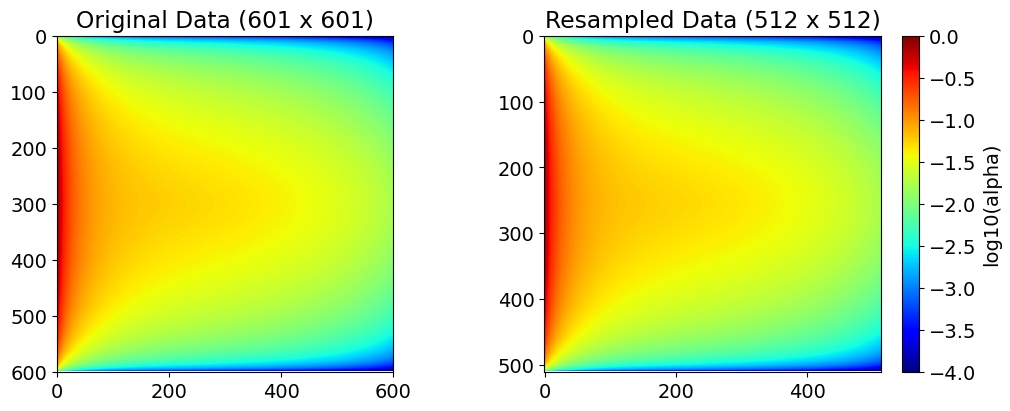

In [64]:
# interpolated data (on a regular grid) can be plotted with imshow as an image
fig, ax = plt.subplots(1,2,figsize=(10, 4), constrained_layout=True)

s = ax[0].imshow(np.log10(MD_EXP["v2d"]["alpha"]), vmin=-4,
        vmax=0,
        cmap="jet")
ax[0].set_title('Original Data (601 x 601)')

s = ax[1].imshow(np.log10(zi), vmin=-4,
        vmax=0,
        cmap="jet")
ax[1].set_title('Resampled Data (512 x 512)')
plt.colorbar(s, label='log10(alpha)', ax=ax[1])

## Helper functions

In [19]:
# Loop through the large .pkl files, save individual items as a separate file
save_dir = f"{config.PATH_TO_DATA}train/train_v2d_alpha_cubic_512x512/"
for i in tqdm([11]):
    labels = np.array(util.load_txt(config.PATH_TO_DATA+f'train/train_labels_{i}.txt').split('\n'))
    data = util.load_result(config.PATH_TO_DATA+f'train/train_v2d_alpha_cubic_512x512_{i}.pkl')
    for j in range(len(data)):
        util.save_result(data[j], save_dir + labels[j] + '.pkl')

100%|██████████| 1/1 [00:04<00:00,  4.94s/it]


In [20]:
# labels are created using `ls *.pkl > train_labels.txt` in the './data/MDISC/small_dataset/train/train_v2d_alpha_cubic_512x512/' directory
filenames = read_filenames(filenames_path=config.PATH_TO_DATA+'train/train_v2d_alpha_cubic_512x512/train_labels.txt')
len(filenames)

10201